In [1]:
%load_ext autoreload
%autoreload 2
from rxnutils import *
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import os
import ast
from rxnmapper import RXNMapper
from chemUtils.synthesis import reaction
import json
from IPython.display import display
from collections import OrderedDict
from prettytable import PrettyTable

In [2]:
with open('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/RXN_SMARTS_CONSTANTS.json', 'r') as f:
    reaction_smarts = json.load(f)
list(reaction_smarts.keys())

['Amidation',
 'Amide_schotten-baumann',
 'Reductive_amination',
 'N-nucleophilic_aromatic_substitution',
 'Sp2-sp2_Suzuki_coupling',
 'Formation_of_urea_from_two_amines',
 'Sulfonamide_Schotten-Baumann_with_amine_(intermolecular)',
 'Buchwald-Hartwig_amination',
 'Epoxide_+_amine_coupling',
 'Nucleophilic_substitution_with_thiol',
 'Mitsunobu_reaction_with_amine_alcohol_and_thioalcohol',
 'Amide_Schotten-Baumann_with_amine',
 'Ester_amidation',
 'Nucleophilic_substitution_with_amine',
 'N-Boc_deprotection']

In [17]:
# Need to check that all reactions in df1 with the name in constants works for the smarts
def check_smarts(df, name_to_check):
    smarts_dict = {}
    for i in range(len(df)):
        row = df.iloc[i]
        for j in range(row.num_steps): # perform for each step in route
            name = ast.literal_eval(row.rxn_order_first_to_last)[j]
            name = name.replace(' ', '_')
            reactants = ast.literal_eval(row.reactants)[j]
            if j > 0:
                poss_prod = ast.literal_eval(row.reactants)[j-1]
                if len(poss_prod) == 1:
                    product = poss_prod[0]
                else:
                    product1 = poss_prod[0]
                    product2 = poss_prod[1]
                    if Chem.MolFromSmiles(product1).GetNumAtoms() > Chem.MolFromSmiles(product2).GetNumAtoms():
                        product = product1
                    else:
                        product = product2
            else:
                product = row.smiles
            if name == name_to_check:
                smarts_name = name.replace(' ', '_')
                mapping = reaction_smarts[smarts_name]
                print('ROW:', i)
                print(reactants)
                if Chem.MolFromSmiles(reactants[0]).GetNumAtoms() == 1:
                    if len(reactants) == 2:
                        if Chem.MolFromSmiles(reactants[1]).GetNumAtoms() == 1:
                            print('ONE ATOM REACTANT')
                            continue
                    else:
                        print('ONE ATOM REACTANT')
                        continue
                outcome = reaction.check_rxn_template_works(mapping, reactants, product, verbose=True)
                print(outcome)
                if outcome[0] != 1:
                    print('FAILED')
                    print(row)
                    display(Chem.MolFromSmiles(reactants[0]))
                    if len(reactants) == 2:
                        display(Chem.MolFromSmiles(reactants[1]))
                    if outcome[0] == 0:
                        print('NO PREDICTED PRODUCT')
                        for i in outcome[1]:
                            display(Chem.MolFromSmiles(i))
                        print('PROPER PRODUCT IS BELOW')
                        display(Chem.MolFromSmiles(product))
                    else:
                        print('PREDICTED PRODUCT(S)')
                        for i in outcome[1]:
                            display(Chem.MolFromSmiles(i))
                        print(outcome[0])
                    break

# CHECKING TWO STEP

ROW: 99
('O=C(CN1CCCCC1)N1CCCC(Br)C1', 'CC(C)(C)O')
The reaction SMARTS is applicable and produces the expected product.
outcome of first combo ['CC(C)(C)OC1CCCN(C(=O)CN2CCCCC2)C1']
The reaction SMARTS is not applicable to the provided reactants.
outcome of second combo []
(1, ['CC(C)(C)OC1CCCN(C(=O)CN2CCCCC2)C1'])
ROW: 129
('Oc1ccon1', 'O=C(CI)NCc1ccncc1C(F)(F)F')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product.
outcome of second combo ['O=C(COc1ccon1)NCc1ccncc1C(F)(F)F']
(1, ['O=C(COc1ccon1)NCc1ccncc1C(F)(F)F'])
ROW: 166
('Oc1cccnc1', 'CCCC(=O)N1CCCC(CNC(=O)CCl)C1')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product.
outcome of second combo ['CCCC(=O)N1CCCC(CNC(=O)COc2cccnc2)C1']
(1, ['CCCC(=O)N1CCCC(CNC(=O)COc2cccnc2)C1'])
ROW: 188
('O=C(NCc1nnc2c(O)nccn12)c1ccc2c(c1)

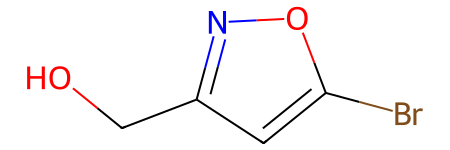

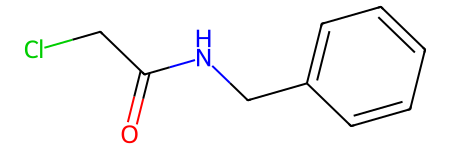

NO PREDICTED PRODUCT


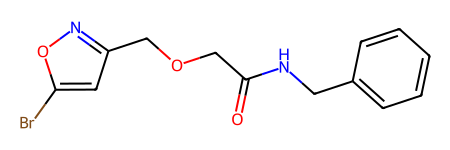

PROPER PRODUCT IS BELOW


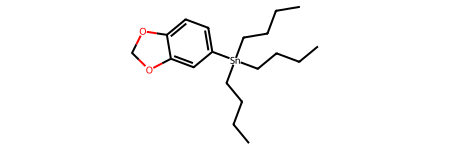

ROW: 286
('Oc1ccon1', 'O=C(CCl)NCc1nnc2ccc(Cl)cn12')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product.
outcome of second combo ['O=C(COc1ccon1)NCc1nnc2ccc(Cl)cn12', 'O=C(CCl)NCc1nnc2ccc(Oc3ccon3)cn12']
(1, ['O=C(COc1ccon1)NCc1nnc2ccc(Cl)cn12', 'O=C(CCl)NCc1nnc2ccc(Oc3ccon3)cn12'])
ROW: 313
('Oc1ccon1', 'O=C(CCl)NCc1nnc2c(Cl)cccn12')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product.
outcome of second combo ['O=C(COc1ccon1)NCc1nnc2c(Cl)cccn12', 'O=C(CCl)NCc1nnc2c(Oc3ccon3)cccn12']
(1, ['O=C(COc1ccon1)NCc1nnc2c(Cl)cccn12', 'O=C(CCl)NCc1nnc2c(Oc3ccon3)cccn12'])
ROW: 332
('Oc1cccnc1', 'O=C(CI)N(Cc1cccnc1)Cc1ccc2c(c1)OCO2')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected pro

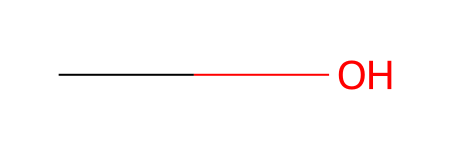

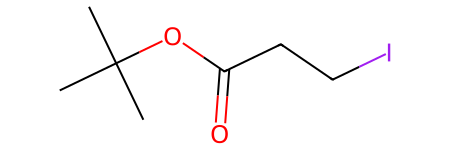

NO PREDICTED PRODUCT


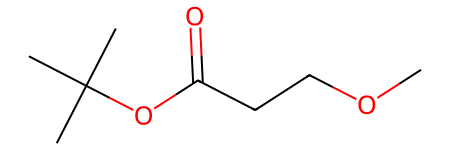

PROPER PRODUCT IS BELOW


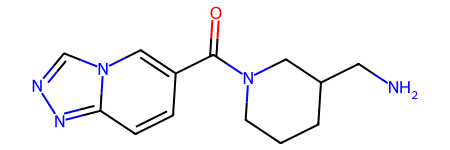

ROW: 433
('CO', 'CC(C)(C)OC(=O)CCI')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable but does not produce the expected product.
outcome of second combo ['COCCC(=O)OC(C)(C)C']
(0, ['COCCC(=O)OC(C)(C)C'])
FAILED
smiles                                      COCCC(=O)NCc1nnc2c(Cl)cc(C(F)(F)F)cn12
num_steps                                                                        2
rxn_order_first_to_last          ['Ester amidation', 'Williamson ether synthesis']
reactants                        [('NCc1nnc2c(Cl)cc(C(F)(F)F)cn12', 'COCCC(=O)O...
BuildingBlocks                   ['CC(C)(C)OC(=O)CCI', 'COCCC(=O)NCc1nnc2c(Cl)c...
catalogName_for_BuildingBlock    ['mcule', 'enamine_bb', 'enamine_real', 'enami...
Name: 433, dtype: object


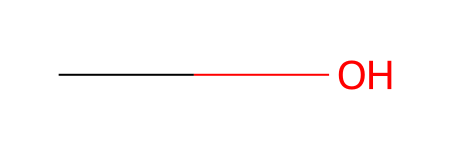

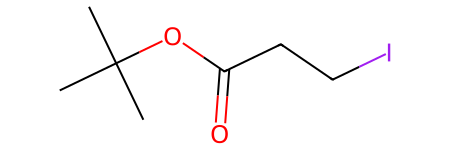

NO PREDICTED PRODUCT


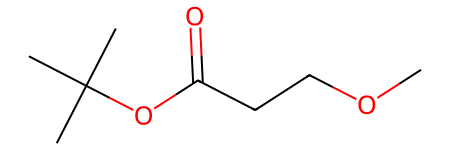

PROPER PRODUCT IS BELOW


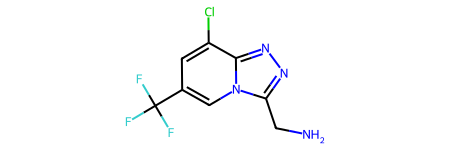

ROW: 492
('COC(=O)C(CO)NC(=O)C=Cc1ccc2c(c1)OCO2', 'C=CCI')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product.
outcome of second combo ['C=CCOCC(NC(=O)C=Cc1ccc2c(c1)OCO2)C(=O)OC']
(1, ['C=CCOCC(NC(=O)C=Cc1ccc2c(c1)OCO2)C(=O)OC'])
ROW: 566
('Oc1ccc2c(c1)OCO2', 'O=C(NCC#CCI)c1ccncc1')
The reaction SMARTS is not applicable to the provided reactants.
outcome of first combo []
The reaction SMARTS is applicable and produces the expected product.
outcome of second combo ['O=C(NCC#CCOc1ccc2c(c1)OCO2)c1ccncc1']
(1, ['O=C(NCC#CCOc1ccc2c(c1)OCO2)c1ccncc1'])


In [37]:
name_to_check = 'Williamson_ether_synthesis'
os.chdir('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/routes_data')
df = pd.read_csv('D68EV3CPROA_enumeration_oct10_first_route_2_step.csv')
#df = pd.read_csv('D68EV3CPROA_enumeration_oct10_first_route_1_step.csv')
reaction_smarts[name_to_check] = "[Cl,Br,I]-[#6:1].[#6;+0:2]-[OH;D1;+0:3]>>[#6X4:1]-[O;H0;D2;+0:3]-[#6X4+0:2]"
with open('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/RXN_SMARTS_CONSTANTS.json', 'w') as f:
    json.dump(reaction_smarts, f)
    
check_smarts(df, name_to_check)

In [35]:
reaction_smarts

{'Amidation': '[#6:1](=[#8:2])-[#8;H1].[#7&X3;!$(NC=*);!$(NS):3]>>[#6:1](=[#8:2])-[#7:3]',
 'Amide_schotten-baumann': '[#7;H2,H1:3].[#6:1](=[#8:2])-[#17]>>[#6:1](=[#8:2])-[#7:3]',
 'Reductive_amination': '[#6:2](=[#8])(-[#6:1]).[#7;H2,H1:3]>>[#6:2](-[#6:1])-[#7:3]',
 'N-nucleophilic_aromatic_substitution': '[#6:3]-[#7;H3,H2,H1:2].[c:1]-[F,Cl,Br,I]>>[#6:3]-[#7:2]-[c:1]',
 'Sp2-sp2_Suzuki_coupling': '[#6X3:1]-[F,Cl,Br,I].[#6X3:2]-[B](-[O])(-[O])>>[#6X3:1]-[#6X3:2]',
 'Formation_of_urea_from_two_amines': '[N&X3;H2,H1;!$(NC=O):3].[N&X3;H2,H1;!$(NC=O):4]>>[#7&X3:3]-[#6](=[#8])-[#7&X3:4]',
 'Sulfonamide_Schotten-Baumann_with_amine_(intermolecular)': '[#16X4:1](=[OX1:2])(=[OX1:3])([#6,#7:4])[#17,#9].[#7&X3;H2,H1;!$(NC=*);!$(NS):5]>>[#16X4:1](=[OX1:2])(=[OX1:3])([#6,#7:4])-[#7:5]',
 'Buchwald-Hartwig_amination': '[ar:1]-[Cl,Br,I].[#7&X3;H2,H1;!$(NC=*);!$(NS);!$(NN):7]>>[ar:1]-[N:7]',
 'Epoxide_+_amine_coupling': '[C:1]-[CH;D3;+0:2]1-[CH2;D2;+0:3]-[O;H0;D2;+0:4]-1.[C:5]-[NH;D2;+0:6]-[C:7]>>[C:1

In [7]:
# Look at already created smarts patterns
with open('/Users/kate_fieseler/PycharmProjects/retrievesynthesizable/D68EV3CPROA/routes_data/all_single_step_max_smarts.json', 'r') as f:
    smarts = json.load(f)
smarts

{'Formation of urea from two amines': [['[C:1]-[NH2;D1;+0:2].[NH2;D1;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c;H0;D3;+0:8](:[cH;D2;+0:9]:[c:10]:1)-[O;H0;D2;+0:11]-[CH2;D2;+0:12]-[#8:13]-2>>[C:1]-[NH;D2;+0:2]-[C;H0;D3;+0:8](=[O;H0;D1;+0:11])-[NH;D2;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c:14](:[cH;D2;+0:9]:[c:10]:1)-[#8:15]-[CH2;D2;+0:12]-[#8:13]-2',
   2],
  ['[C:1]-[NH2;D1;+0:2].[NH2;D1;+0:3]-[C:4]-[c:5]1:[c:6]:[c:7]:[c;H0;D3;+0:8]2:[c;H0;D3;+0:9](:[cH;D2;+0:10]:1)-[O;H0;D2;+0:11]-[CH2;D2;+0:12]-[#8:13]-2>>[C:1]-[NH;D2;+0:2]-[C;H0;D3;+0:9](=[O;H0;D1;+0:11])-[NH;D2;+0:3]-[C:4]-[c:5]1:[c:6]:[c:7]:[c;H0;D3;+0:8]2:[c:14](:[cH;D2;+0:10]:1)-[#8:15]-[CH2;D2;+0:12]-[#8:13]-2',
   2],
  ['[C:1]-[NH2;D1;+0:2].[NH2;D1;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c;H0;D3;+0:8](:[cH;D2;+0:9]:[c:10]:1)-[O;H0;D2;+0:11]-[CH2;D2;+0:12]-[#8:13]-2>>[C:1]-[NH;D2;+0:2]-[C;H0;D3;+0:8](=[O;H0;D1;+0:11])-[NH;D2;+0:3]-[C:4]-[c:5]1:[c:6]:[c;H0;D3;+0:7]2:[c:14](:[cH;D2;+0:9]:[c:10]:1)-[#8:15]-[CH2;D2;+0:12]-[

In [34]:
smarts['Alkene hydrogenation (unconjugated)']

KeyError: 'Alkene hydrogenation (unconjugated)'

In [27]:
test = AllChem.ReactionFromSmarts('[Cl,O=S]>>[Cl,O=S(=O)(C(F)(F)F)]')
print(test)

ValueError: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [Cl,O=S]